## Importing Required Libraries

In this section, we import the necessary libraries for data handling, model training, feature selection, and evaluation.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd


import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, Parallel, delayed
from xgboost import XGBClassifier  # XGBoost classifier
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    accuracy_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
import warnings  # Import the warnings module
from matplotlib import cm

## Setup and Define Model Parameters

Here we define input parameters such as file paths, hyperparameters, and directories for saving results.

In [2]:
# INPUT DATA
dataset_name = 'SB10r'
reduction_method1 = '_n0.2_process1'
reduction_method2 = '_n0.2_process2'
base_path = 'InputModel'
output_file1 = os.path.join(base_path, f'{dataset_name}{reduction_method1}.csv')
output_file2 = os.path.join(base_path, f'{dataset_name}{reduction_method2}.csv')
# Load the newly generated CSV file
df1 = pd.read_csv(output_file1)
df2 = pd.read_csv(output_file2)
# Concatenate the two DataFrames
df = pd.concat([df1, df2], ignore_index=True)
# print the number of rows
print(f"Number of rows: {len(df)}")

Number of rows: 3230048


In [3]:
# print column names
print(df.columns)

Index(['FIELDID', 'Crop_type', 'Crop_num', 'area_ha', 'Year', 'week',
       'chirps_mean_prec', 'chirps_sum_prec', 'chirps_max_prec',
       'chirps_min_prec', 'chirps_std_prec', 'chirps_cnt_prec', 'era5_temp2m',
       'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh',
       'era5_swi', 'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi',
       'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi',
       'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi',
       'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr',
       'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi',
       'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 'sar_vh',
       'sar_vv', 'sar_angle', 'sar_sigma_vh_linear', 'sar_sigma_vv_linear',
       'sar_p_ratio', 'sar_rvi', 'sar_rcspr', 'Irrigation'],
      dtype='object')


In [4]:
# Rename all columns starting with "sar_" to "s1_"
df.rename(columns={col: col.replace('sar_', 's1_') for col in df.columns if col.startswith('sar_')}, inplace=True)
# print column names
print(df.columns)


Index(['FIELDID', 'Crop_type', 'Crop_num', 'area_ha', 'Year', 'week',
       'chirps_mean_prec', 'chirps_sum_prec', 'chirps_max_prec',
       'chirps_min_prec', 'chirps_std_prec', 'chirps_cnt_prec', 'era5_temp2m',
       'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh',
       'era5_swi', 'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi',
       'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi',
       'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi',
       'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr',
       'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi',
       'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 's1_vh',
       's1_vv', 's1_angle', 's1_sigma_vh_linear', 's1_sigma_vv_linear',
       's1_p_ratio', 's1_rvi', 's1_rcspr', 'Irrigation'],
      dtype='object')


In [5]:
# print unique values in 'Crop_type' and their counts
print(df['Crop_type'].value_counts())
# print the number of unique fields per crop type
print(df.groupby('Crop_type')['FIELDID'].nunique())



Crop_type
Pasture       845912
Maize         732704
Soy           535432
Fallow        391235
Sunflower     319364
Tree          167765
Wheat         111124
Lucern         78783
Sorghum        30825
Groundnuts     16904
Name: count, dtype: int64
Crop_type
Fallow        16756
Groundnuts     1074
Lucern         2944
Maize         34696
Pasture       43555
Sorghum        1595
Soy           24412
Sunflower     16099
Tree           1612
Wheat          4827
Name: FIELDID, dtype: int64


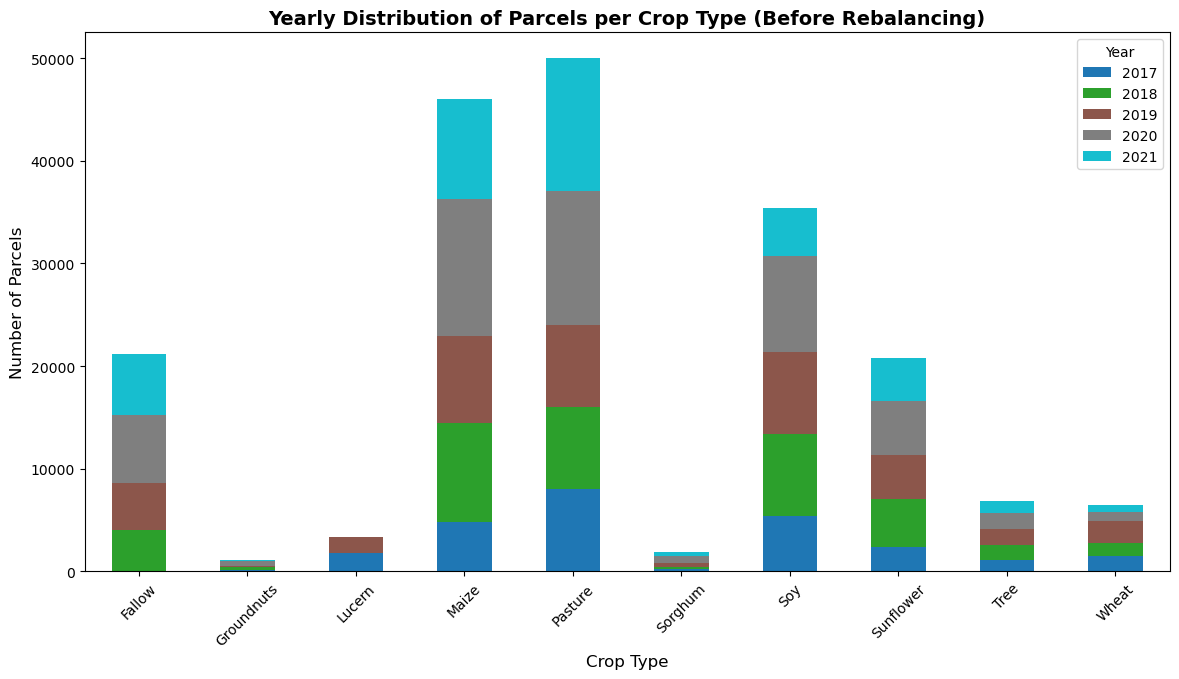

In [6]:
# Ensure required columns exist
required_columns = {"Crop_type", "FIELDID", "Year"}
missing = required_columns - set(df.columns)
if missing:
    raise ValueError(f"The dataframe df3 is missing the columns: {missing}")

# Compute the number of unique FIELDIDs per crop per year before rebalancing
crop_year_counts_original = df.groupby(["Crop_type", "Year"])["FIELDID"].nunique().unstack()

# Plot the original distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_original.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Before Rebalancing)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()

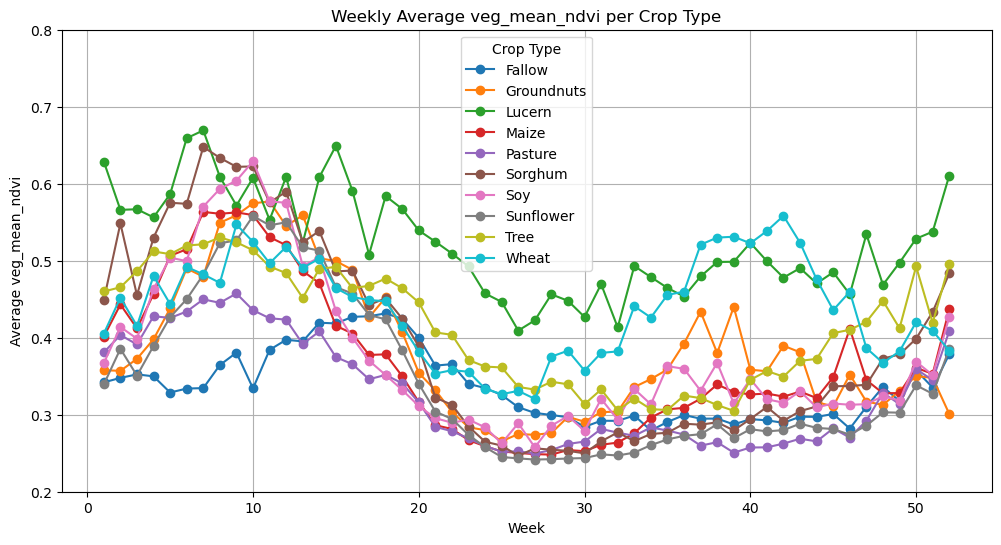

In [7]:
# Ensure 'week' and 'veg_mean_ndvi' are numeric
df["week"] = pd.to_numeric(df["week"], errors="coerce")
df["veg_mean_ndvi"] = pd.to_numeric(df["veg_mean_ndvi"], errors="coerce")

# Compute average veg_mean_ndvi per crop type per week
avg_ndvi_per_crop = df.groupby(["Crop_type", "week"], as_index=False)["veg_mean_ndvi"].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each crop type's average NDVI time series
gap_threshold = 2  # max allowed week gap to keep the line

for crop in avg_ndvi_per_crop["Crop_type"].unique():
    subset = avg_ndvi_per_crop[avg_ndvi_per_crop["Crop_type"] == crop].sort_values("week")
    weeks = subset["week"].values
    ndvi_values = subset["veg_mean_ndvi"].values

    # Insert NaN where the gap is larger than threshold
    new_weeks = []
    new_ndvi = []
    for i in range(len(weeks)):
        new_weeks.append(weeks[i])
        new_ndvi.append(ndvi_values[i])
        if i < len(weeks) - 1 and (weeks[i+1] - weeks[i]) > gap_threshold:
            new_weeks.append(np.nan)
            new_ndvi.append(np.nan)

    plt.plot(new_weeks, new_ndvi, marker="o", linestyle="-", label=crop)

# Customize the plot
plt.xlabel("Week")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Weekly Average veg_mean_ndvi per Crop Type")
plt.legend(title="Crop Type")
plt.grid(True)
plt.ylim(0.2, 0.8)

# Show the plot
plt.show()


In [8]:
# Define invalid week ranges for summer crops and others
invalid_weeks = {
    "Maize": (22, 40),
    "Soy": (22, 40),
    "Sunflower": (22, 40),
    "Pasture": (22, 40),  
    "Tree": (22, 40),  
    "Fallow": (22, 40),
    "Groundnuts": (22, 40),
    "Sorghum": (22, 40),
    "Wheat": (47, 17),  # invalid weeks outside 17–47
    # Lucern handled separately
}

# Function to check if a sample should be removed
def is_invalid_sample(crop, week, irrigation):
    # Special rule for Lucern
    if crop == "Lucern":
        if irrigation == 1:  # irrigated: only weeks 17–47
            if week < 17 or week > 47:
                return True
        else:  # rainfed: same as Maize, i.e. invalid in 22–40
            if 22 <= week <= 40:
                return True
        return False

    # General week-based filtering
    if crop in invalid_weeks:
        out_start, out_end = invalid_weeks[crop]
        if out_start < out_end:
            if out_start <= week <= out_end:
                return True
        else:
            if week >= out_start or week <= out_end:
                return True

    return False

# Apply filtering
df_filtered = df[~df.apply(lambda row: is_invalid_sample(row["Crop_type"], row["week"], row["Irrigation"]), axis=1)]

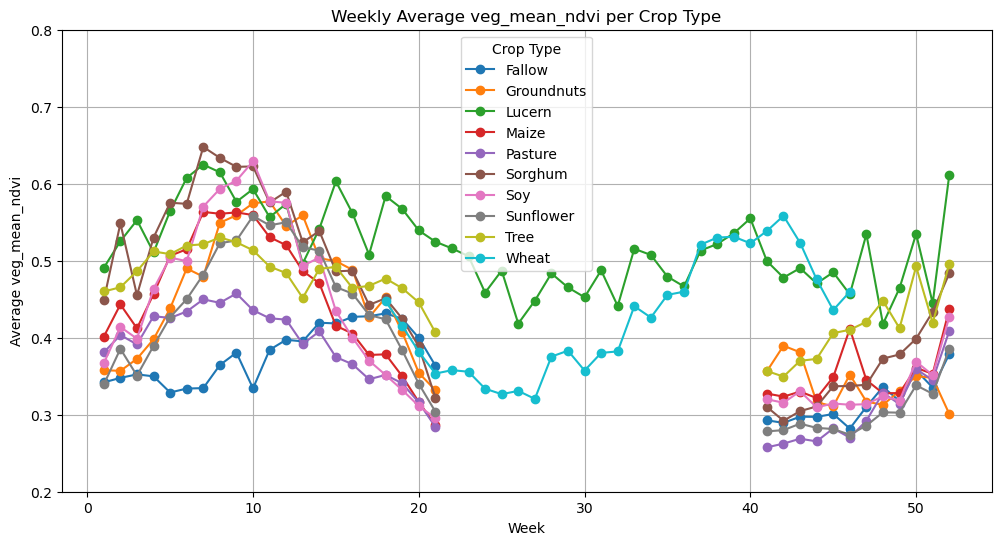

In [9]:
# Ensure 'week' and 'veg_mean_ndvi' are numeric
df_filtered.loc[:, "week"] = pd.to_numeric(df_filtered["week"], errors="coerce")
df_filtered.loc[:, "veg_mean_ndvi"] = pd.to_numeric(df_filtered["veg_mean_ndvi"], errors="coerce")


# Compute average veg_mean_ndvi per crop type per week
avg_ndvi_per_crop = df_filtered.groupby(["Crop_type", "week"], as_index=False)["veg_mean_ndvi"].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each crop type's average NDVI time series
gap_threshold = 2  # max allowed week gap to keep the line

for crop in avg_ndvi_per_crop["Crop_type"].unique():
    subset = avg_ndvi_per_crop[avg_ndvi_per_crop["Crop_type"] == crop].sort_values("week")
    weeks = subset["week"].values
    ndvi_values = subset["veg_mean_ndvi"].values

    # Insert NaN where the gap is larger than threshold
    new_weeks = []
    new_ndvi = []
    for i in range(len(weeks)):
        new_weeks.append(weeks[i])
        new_ndvi.append(ndvi_values[i])
        if i < len(weeks) - 1 and (weeks[i+1] - weeks[i]) > gap_threshold:
            new_weeks.append(np.nan)
            new_ndvi.append(np.nan)

    plt.plot(new_weeks, new_ndvi, marker="o", linestyle="-", label=crop)

# Customize the plot
plt.xlabel("Week")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Weekly Average veg_mean_ndvi per Crop Type")
plt.legend(title="Crop Type")
plt.grid(True)
plt.ylim(0.2, 0.8)

# Show the plot
plt.show()

In [10]:
# Print dataset size before and after filtering
print(f"Original dataset size: {df.shape[0]}")
print(df['Crop_type'].value_counts())
print(f"Filtered dataset size: {df_filtered.shape[0]}")
print(df_filtered['Crop_type'].value_counts())

Original dataset size: 3230048
Crop_type
Pasture       845912
Maize         732704
Soy           535432
Fallow        391235
Sunflower     319364
Tree          167765
Wheat         111124
Lucern         78783
Sorghum        30825
Groundnuts     16904
Name: count, dtype: int64
Filtered dataset size: 2603423
Crop_type
Pasture       720161
Maize         590578
Soy           458909
Fallow        281536
Sunflower     263512
Tree          114090
Wheat          83063
Lucern         52714
Sorghum        24577
Groundnuts     14283
Name: count, dtype: int64


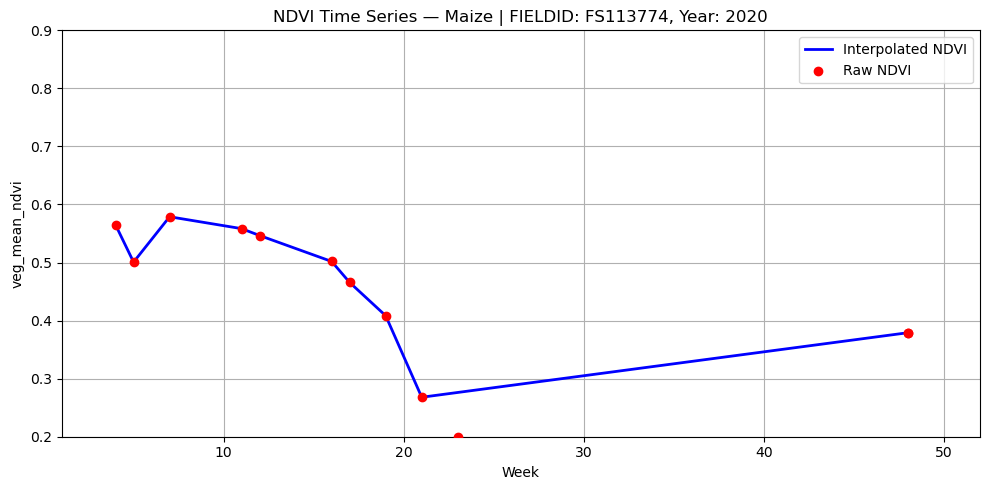

In [11]:
# Pick one random FIELDID-Year pair
sample_pair = df[['FIELDID', 'Year']].drop_duplicates().sample(1)
fid = sample_pair.iloc[0]['FIELDID']
year = sample_pair.iloc[0]['Year']

# Raw NDVI: before interpolation
ndvi_raw = df[(df['FIELDID'] == fid) & (df['Year'] == year)].sort_values('week')[['week', 'veg_mean_ndvi']].dropna()
weeks_raw = ndvi_raw['week'].astype(int).to_numpy()

# Interpolated NDVI
ndvi_interp = df_filtered[(df_filtered['FIELDID'] == fid) & (df_filtered['Year'] == year)].sort_values('week')[['week', 'veg_mean_ndvi']].dropna()
weeks_interp = ndvi_interp['week'].astype(int).to_numpy()
ndvi_interp_vals = ndvi_interp['veg_mean_ndvi'].to_numpy()

# Identify interpolated-only weeks (those not in raw)
interp_only_weeks = sorted(set(weeks_interp) - set(weeks_raw))
# interp_only_vals = ndvi_interp[ndvi_interp['week'].isin(interp_only_weeks)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(weeks_interp, ndvi_interp_vals, label='Interpolated NDVI', color='blue', linewidth=2)
plt.scatter(weeks_raw, ndvi_raw['veg_mean_ndvi'], color='red', label='Raw NDVI', zorder=5)
# plt.scatter(interp_only_vals['week'], interp_only_vals['veg_mean_ndvi'], color='skyblue', label='Interpolated Only', marker='o', edgecolors='black', zorder=4)

# Title
crop_type = df_filtered.loc[(df_filtered['FIELDID'] == fid) & (df_filtered['Year'] == year), 'Crop_type'].iloc[0]
plt.title(f'NDVI Time Series — {crop_type} | FIELDID: {fid}, Year: {year}')

# Axis labels
plt.xlabel('Week')
plt.ylabel('veg_mean_ndvi')

# Fix axis ranges
plt.xlim(1, 52)
plt.ylim(0.2, 0.9)

# Final touches
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# print the number of unique fields per crop type
print(df_filtered.groupby('Crop_type')['FIELDID'].nunique())

Crop_type
Fallow        16756
Groundnuts     1074
Lucern         2944
Maize         34696
Pasture       43555
Sorghum        1595
Soy           24412
Sunflower     16099
Tree           1612
Wheat          4827
Name: FIELDID, dtype: int64


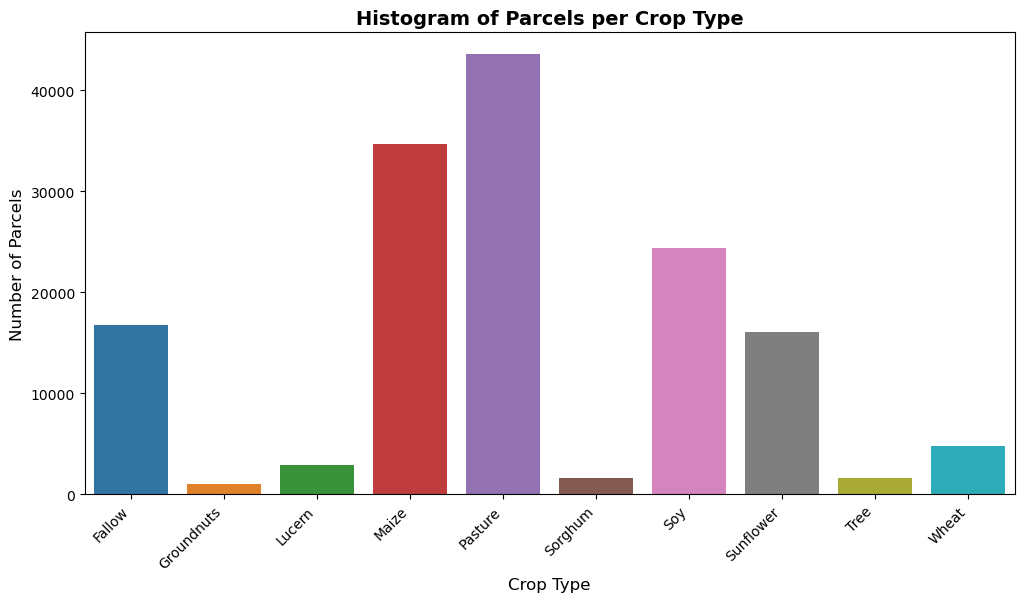

In [13]:
# Ensure Crop_type column exists
if "Crop_type" not in df_filtered.columns:
    raise ValueError("The dataframe df is missing the 'Crop_type' column.")

# Count unique FIELDID values per Crop_type
crop_counts = df_filtered.groupby('Crop_type')['FIELDID'].nunique().reset_index()
crop_counts.columns = ['Crop_type', 'Parcel_Count']

# Define distinct colors for each crop type
colors = plt.cm.get_cmap('tab10', len(crop_counts))  # Use 'tab10' colormap
crop_color_map = {crop: colors(i) for i, crop in enumerate(crop_counts['Crop_type'])}

# Plot the histogram
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x='Crop_type', y='Parcel_Count', data=crop_counts,
    palette=[crop_color_map[crop] for crop in crop_counts['Crop_type']]
)

# Improve readability
ax.set_title("Histogram of Parcels per Crop Type", fontsize=14, fontweight='bold')
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.set_xticklabels(crop_counts['Crop_type'], rotation=45, ha='right')  # Rotate x-axis labels

plt.show()

In [14]:
type_num = df_filtered[['Crop_type', 'Crop_num']].drop_duplicates()
print(type_num.sort_values(by='Crop_num'))

          Crop_type  Crop_num
0             Maize         0
377481          Soy         1
712924    Sunflower         2
894461        Wheat         3
975664       Lucern         4
1054441     Pasture         5
1465547        Tree         6
1569024      Fallow         7
1729372  Groundnuts         8
1738173     Sorghum         9


<AxesSubplot:xlabel='Crop_type'>

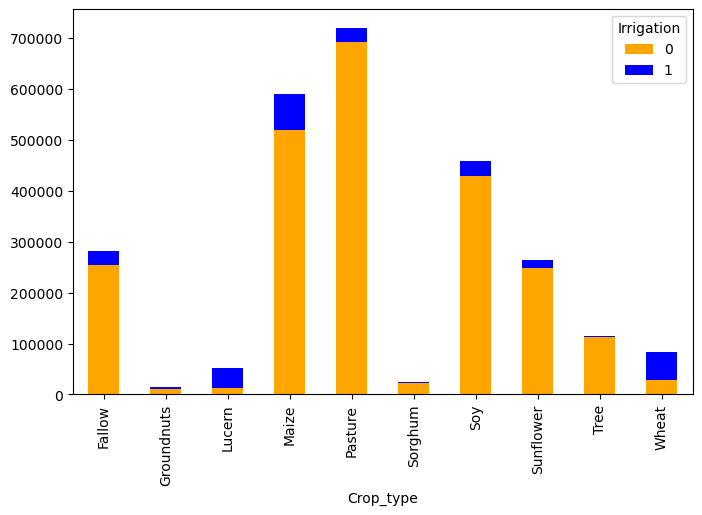

In [15]:
# plot histogram of Irrigation by Crop_type
df_filtered.groupby(['Crop_type', 'Irrigation']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['orange', 'blue'],  # 0 = orange (Rainfed), 1 = blue (Irrigated)
    figsize=(8, 5)
)

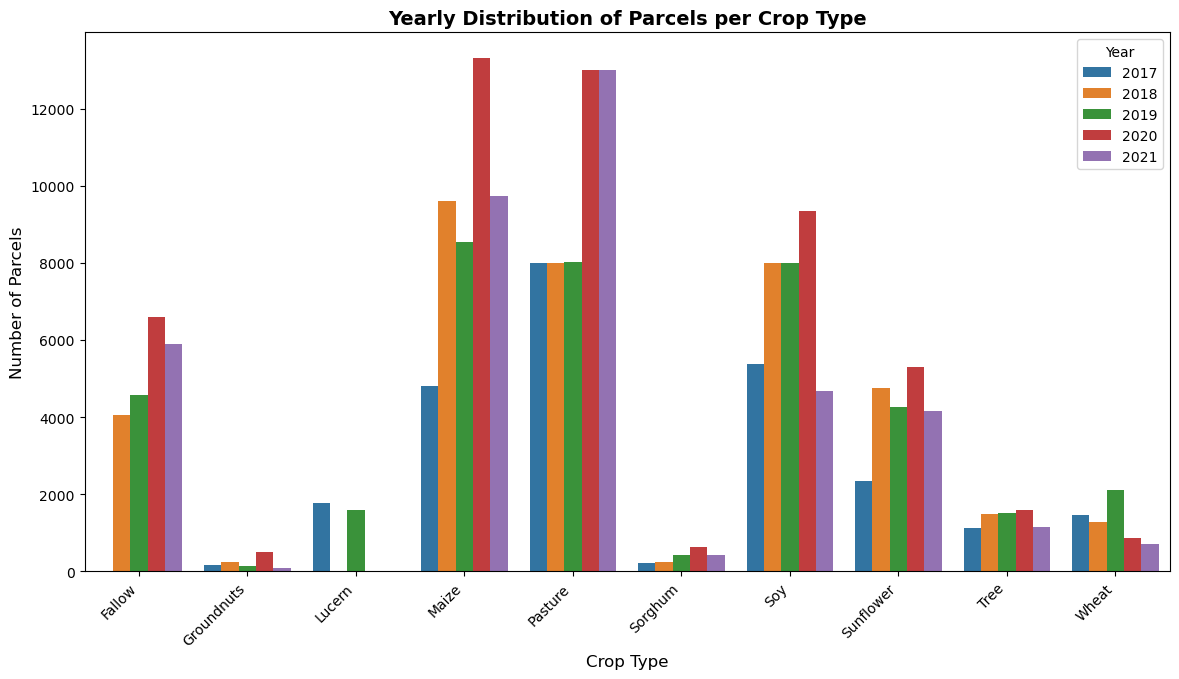

In [16]:
import seaborn as sns
# Ensure required columns exist
if "Crop_type" not in df_filtered.columns or "Year" not in df_filtered.columns:
    raise ValueError("The dataframe df is missing required columns ('Crop_type' or 'Year').")

# Count unique parcels per Crop_type and Year
crop_year_counts = df_filtered.groupby(['Crop_type', 'Year'])['FIELDID'].nunique().reset_index()
crop_year_counts.columns = ['Crop_type', 'Year', 'Parcel_Count']

# Set figure size
fig, ax = plt.subplots(figsize=(14, 7))

# Use a color palette with enough distinct colors
palette = sns.color_palette("tab10", len(crop_year_counts['Year'].unique()))

# Create the bar plot
sns.barplot(
    x='Crop_type', y='Parcel_Count', hue='Year', data=crop_year_counts,
    palette=palette, dodge=True, ax=ax
)

# Improve readability
ax.set_title("Yearly Distribution of Parcels per Crop Type", fontsize=14, fontweight='bold')
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.set_xticklabels(crop_year_counts['Crop_type'].unique(), rotation=45, ha='right')  # Rotate x-axis labels
ax.legend(title="Year")

plt.show()

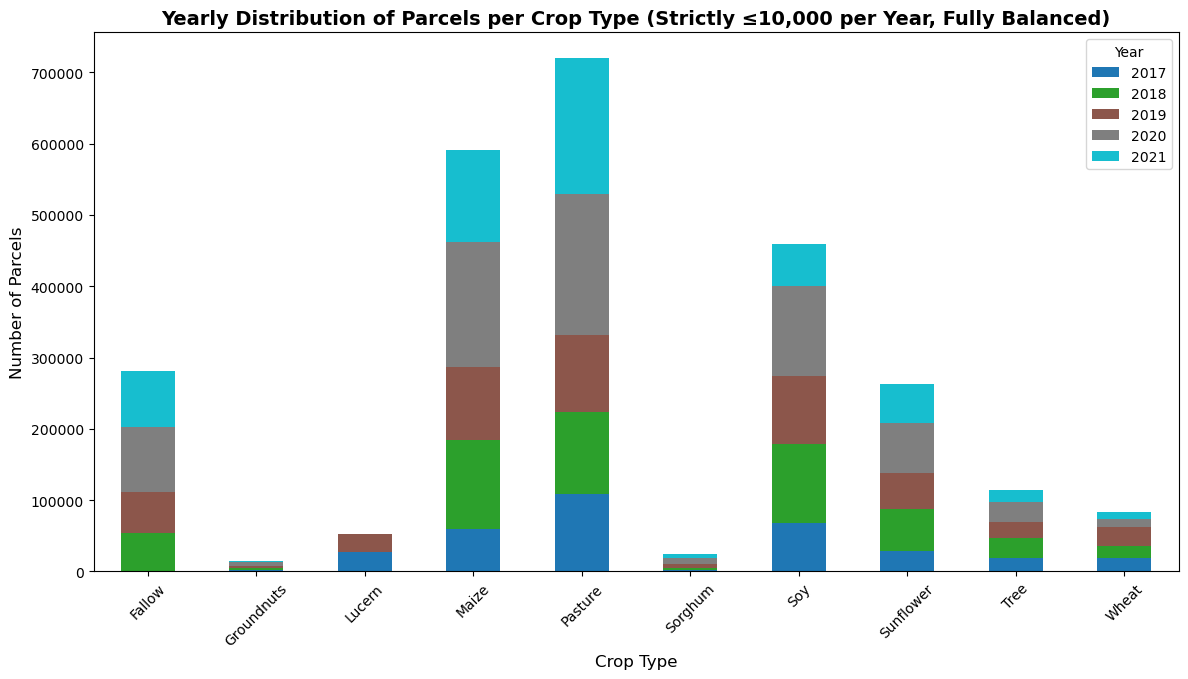

In [17]:


# Verify new unique FIELDID counts per crop and year
crop_year_counts_balanced = df_filtered.groupby(["Crop_type", "Year"]).size().unstack()


# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Strictly ≤10,000 per Year, Fully Balanced)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()


# # # extract only Wheat from df and save as csv file
# df_wheat = df[df['Crop_type'] == 'Wheat']
# output_file = os.path.join(base_path, f'df_Wheat.csv')
# df_wheat.to_csv(output_file, index=False)

In [18]:

df_filtered = df_filtered.copy()  # Ensure df_filtered is not a slice to avoid SettingWithCopyWarning

# Feature Engineering
df_filtered.loc[:, 'week_sin'] = np.sin(2 * np.pi * df_filtered['week'] / 52)
df_filtered.loc[:, 'week_cos'] = np.cos(2 * np.pi * df_filtered['week'] / 52)
df_filtered.loc[:, 'growth_rate_ndvi'] = df_filtered['veg_max_ndvi'] - df_filtered['veg_min_ndvi']
df_filtered.loc[:, 'growth_rate_evi'] = df_filtered['veg_max_evi'] - df_filtered['veg_min_evi']
df_filtered.loc[:, 'growth_rate_lai'] = df_filtered['veg_max_lai'] - df_filtered['veg_min_lai']
df_filtered.loc[:, 'mean_combined_vegetation_index'] = (df_filtered['veg_mean_evi'] + df_filtered['veg_mean_ndvi'] + df_filtered['veg_mean_lai']) / 3


In [19]:
# Add ndvi_evi_ratio
df_filtered = df_filtered.copy()  # Ensure df is a new DataFrame to prevent SettingWithCopyWarning
df_filtered.loc[:, 'ndvi_evi_ratio'] = df_filtered['veg_mean_ndvi'] / (df_filtered['veg_mean_evi'] + 1e-6)

In [20]:
# Map numerical labels to crop names
crop_name_mapping = dict(zip(df_filtered['Crop_num'].unique(), df_filtered['Crop_type'].unique()))

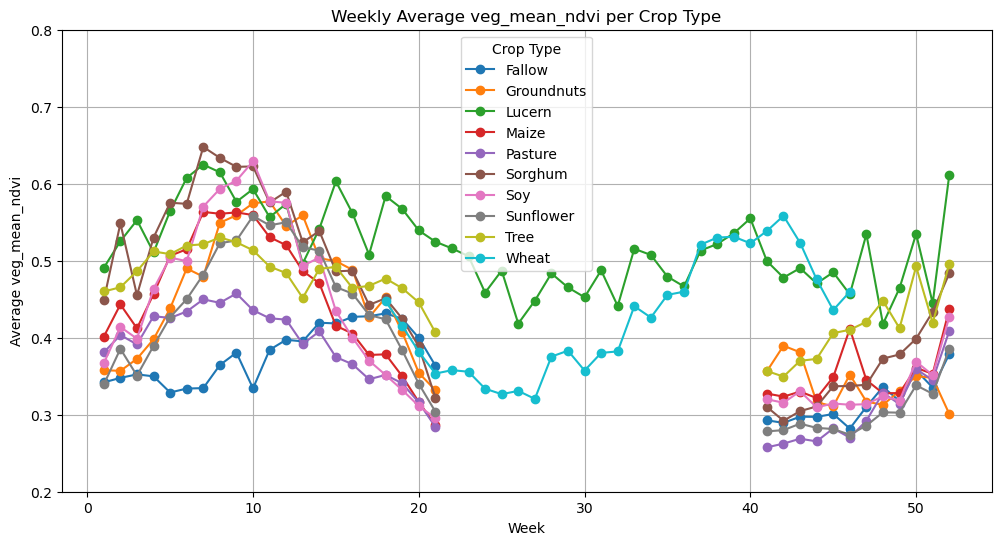

In [21]:
# Ensure 'week' and 'veg_mean_ndvi' are numeric
df_filtered["week"] = pd.to_numeric(df_filtered["week"], errors="coerce")
df_filtered["veg_mean_ndvi"] = pd.to_numeric(df_filtered["veg_mean_ndvi"], errors="coerce")

# Compute average veg_mean_ndvi per crop type per week
avg_ndvi_per_crop = df_filtered.groupby(["Crop_type", "week"], as_index=False)["veg_mean_ndvi"].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each crop type's average NDVI time series
gap_threshold = 2  # max allowed week gap to keep the line

for crop in avg_ndvi_per_crop["Crop_type"].unique():
    subset = avg_ndvi_per_crop[avg_ndvi_per_crop["Crop_type"] == crop].sort_values("week")
    weeks = subset["week"].values
    ndvi_values = subset["veg_mean_ndvi"].values

    # Insert NaN where the gap is larger than threshold
    new_weeks = []
    new_ndvi = []
    for i in range(len(weeks)):
        new_weeks.append(weeks[i])
        new_ndvi.append(ndvi_values[i])
        if i < len(weeks) - 1 and (weeks[i+1] - weeks[i]) > gap_threshold:
            new_weeks.append(np.nan)
            new_ndvi.append(np.nan)

    plt.plot(new_weeks, new_ndvi, marker="o", linestyle="-", label=crop)

# Customize the plot
plt.xlabel("Week")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Weekly Average veg_mean_ndvi per Crop Type")
plt.legend(title="Crop Type")
plt.grid(True)
plt.ylim(0.2, 0.8)

# Show the plot
plt.show()


In [22]:
# Save df_limited to a new CSV file
out_path = 'InputModel'
# use boosting factor in the output filename
output_filename = os.path.join(out_path, f'{dataset_name}_n0.2_process_filt.csv')
df_filtered.to_csv(output_filename, index=False)


In [23]:
# df_map = df_filtered.copy()

# # Merge both datasets (all parcels)
# gdf_fs = gpd.read_file(os.path.join("Data/geo/parcels", "FS.geojson"))
# gdf_nw = gpd.read_file(os.path.join("Data/geo/parcels", "NW.geojson"))

# # Ensure both datasets have a geometry column
# if "geometry" not in gdf_fs.columns or "geometry" not in gdf_nw.columns:
#     raise ValueError("One of the datasets is missing a geometry column.")

# # Merge into gdf_total (all parcels)
# gdf_total = pd.concat([gdf_fs, gdf_nw], axis=0, ignore_index=True)

# # Ensure 'geometry' exists and is valid
# if "geometry" not in gdf_total.columns:
#     raise ValueError("gdf_total is missing the geometry column after merging.")

# # Drop rows with missing geometry
# gdf_total = gdf_total.dropna(subset=['geometry'])
# gdf_total = gpd.GeoDataFrame(gdf_total, geometry='geometry', crs=gdf_fs.crs)

# # Count total unique parcels
# total_parcels = gdf_total['FIELDID'].nunique()

# # **Fix missing geometry in df**
# if "geometry" not in df_map.columns:
#     print("Restoring geometry column in df...")
#     df_map = df_map.merge(gdf_total[['FIELDID', 'geometry']], on='FIELDID', how='left')

# # Ensure geometry exists before proceeding
# df_map = df_map.dropna(subset=['geometry'])  # Remove rows where geometry is missing
# gdf_crop = gpd.GeoDataFrame(df_map, geometry='geometry', crs=gdf_fs.crs)

# # Ensure Crop_type column exists before proceeding
# if "Crop_type" not in gdf_crop.columns:
#     raise ValueError("The dataframe df is missing the 'Crop_type' column.")

# # Count unique FIELDID values per Crop_type
# crop_counts = gdf_crop.groupby('Crop_type')['FIELDID'].nunique().to_dict()  # Count unique parcels

# # Count unique parcels in gdf_crop
# crop_parcels = gdf_crop['FIELDID'].nunique()

# # Define distinct colors for each crop type
# colors = plt.cm.get_cmap('tab10', len(crop_counts))  # Use 'tab10' for distinct colors
# crop_color_map = {crop: colors(i) for i, crop in enumerate(crop_counts.keys())}

# # Plot the map
# fig, ax = plt.subplots(figsize=(12, 12))

# # Plot total parcels as a soft gray background
# gdf_total.plot(ax=ax, color='lightgray', edgecolor='none', alpha=0.5)

# # Overlay parcels colored by crop type
# gdf_crop.plot(ax=ax, color=gdf_crop['Crop_type'].map(crop_color_map), edgecolor='white', linewidth=0.3, alpha=0.8)

# # Create a legend with crop type and unique parcel count
# legend_labels = [f"{c} ({crop_counts[c]})" for c in crop_counts.keys()]
# handles = [
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=crop_color_map[c], markersize=10)
#     for c in crop_counts.keys()
# ]

# # Update legend title to include both total and crop parcel counts
# legend_title = f"Crop Type (Parcels)\nTotal Parcels: {total_parcels}\nCrop Parcels: {crop_parcels}"

# ax.legend(handles, legend_labels, title=legend_title, loc='upper right')

# # Improve title and axis labels
# ax.set_title("Parcels Map Colored by Crop Type", fontsize=14, fontweight='bold')
# ax.set_xlabel("Longitude", fontsize=12)
# ax.set_ylabel("Latitude", fontsize=12)